In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
def read_mprof(path):
    times = []
    mem = []
    func_ts = {}
    with open(path) as fd:
        for l in fd:
            key, val = l.split(' ', 1)
            if key == 'MEM':
                values = val.split(' ')
                mem.append(float(values[0]))
                times.append(float(values[1]))
            elif key == 'FUNC':
                values = val.split(' ')
                fname, mem_start, start, mem_end, end = values[:5]
                ts = func_ts.get(fname, [])
                ts.append([float(start), float(end), float(mem_start), float(mem_end)])
                func_ts[fname] = ts
    return {
        'mem_usage': np.array([times, mem]).transpose(),
        'func_timestamp': func_ts
    }

In [3]:
def plot_mprof(mprof_data):
    mem_usage = mprof_data['mem_usage']
    ts = mprof_data['func_timestamp']
    # Memory
    plt.plot(mem_usage[:, 0], mem_usage[:, 1])
    # Max value
    max_val = max(mem_usage[:, 1])
    plt.plot(mem_usage[[0,-1],0], [max_val, max_val], 'r--', label="%.2f MB" % max_val)
    # Functions
    i = 0
    style = ['v', '^', '<', '>']
    for f, exec_ts in ts.items():
        f = f.replace('_', '')
        for execution in exec_ts:
            start, end, mstart, mend = execution
            plt.plot([start, end], [mstart, mend], style[i % len(style)] + ':', label=f)
            i += 1
    # Legend
    plt.legend()

### Before changes

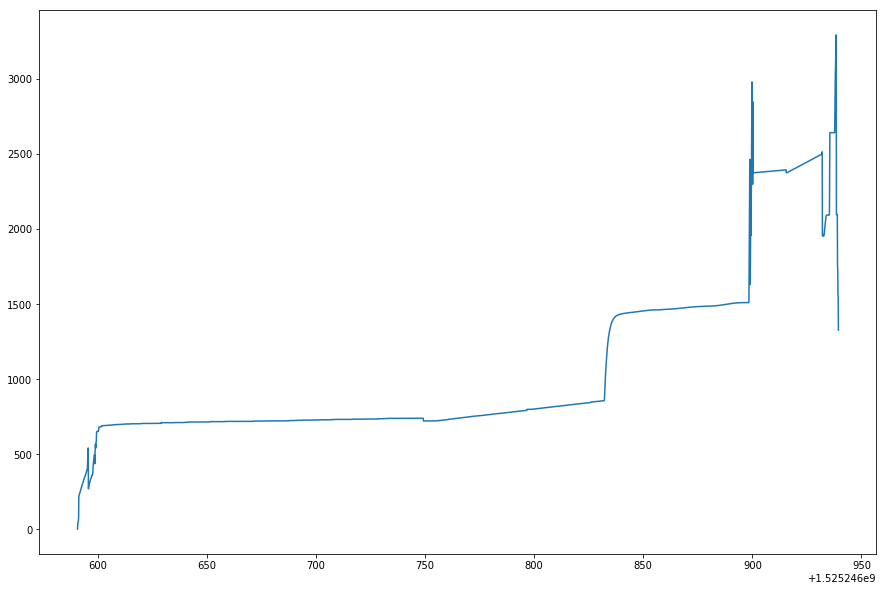

In [4]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180502093630.dat')
plot_mprof(mprof_data)

### After changes

3075.8359380000002

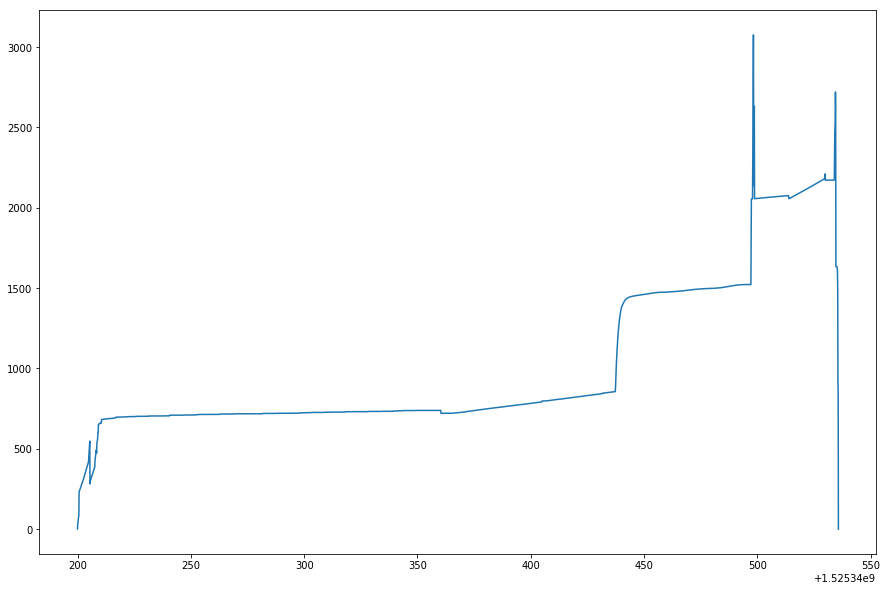

In [5]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180503113639.dat')['mem_usage']
_ = plt.plot(mprof_data[:, 0], mprof_data[:, 1])
max(mprof_data[:, 1])

An absolute disaster. Nothing changes :( (Well, the second peak isn't as bad, but peak consumption is the same)
By the way, it is .save where the two peaks happen.

### Trying to restrict where is this happening

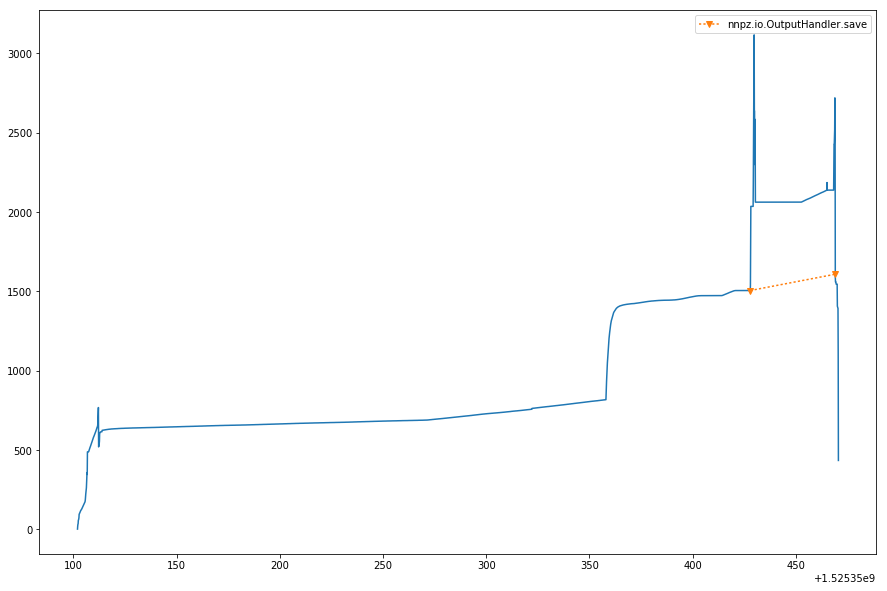

In [6]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180503142141.dat')
plot_mprof(mprof_data)

Let's try restricting this more.

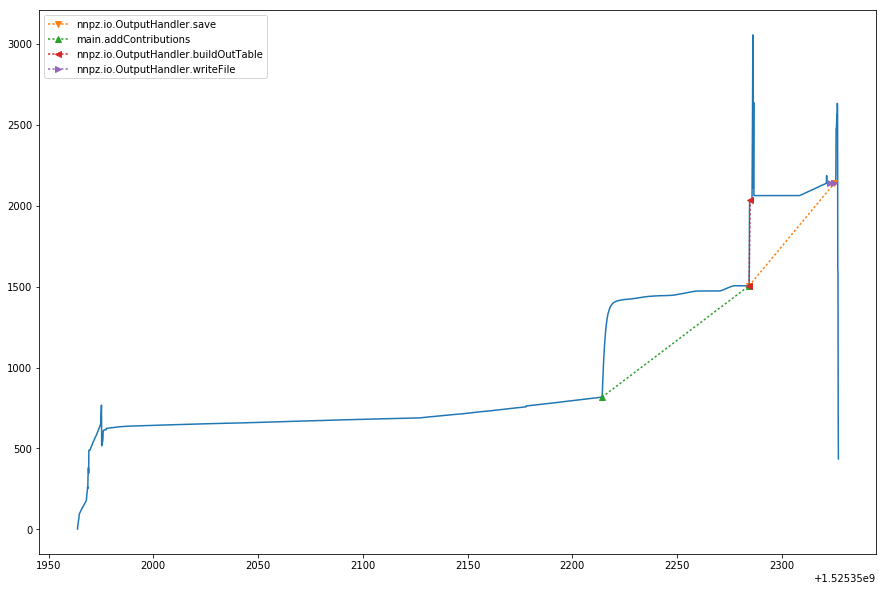

In [7]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180503145243.dat')
plot_mprof(mprof_data)

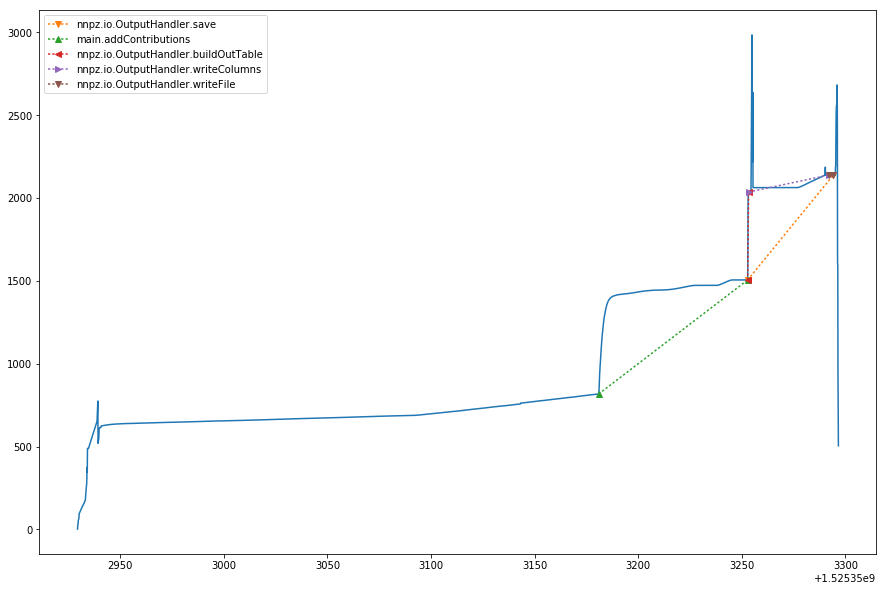

In [8]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180503150849.dat')
plot_mprof(mprof_data)

Ok, so the first peak is when writting the columns. The changes I did didn't solve this issue.
The second is clearly a resolution issue. It happens when saving.

Oooooh... I think HDUList creates a copy. Let's try.

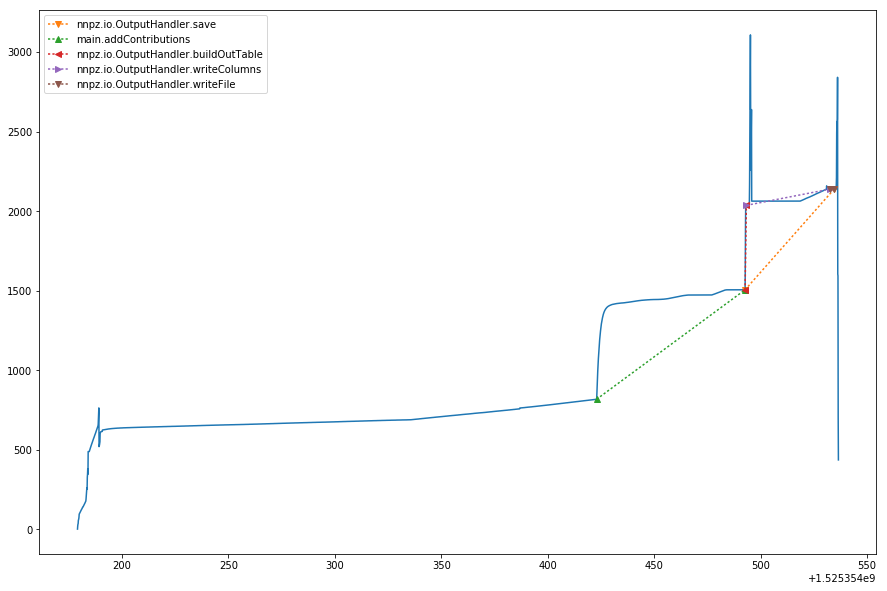

In [9]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180503152939.dat')
plot_mprof(mprof_data)

Damn it. It doesn't solve anything. What is writeto doing??

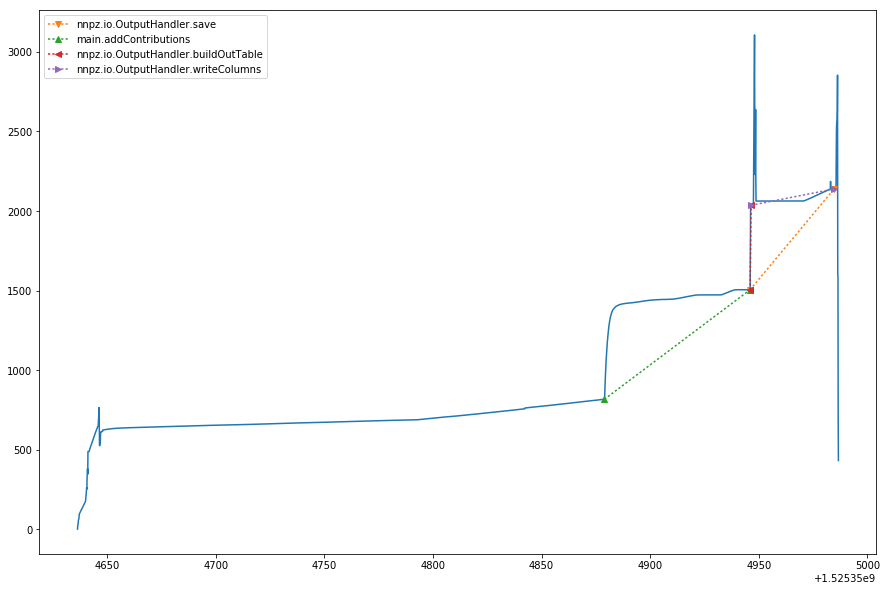

In [10]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180503153716.dat')
plot_mprof(mprof_data)

I am very much confused. writeFile isn't it. I am going to instrumentalize the extra hdul code as well, and put a bunch of time.sleep(1) at the end of the wrapper functions, to make sure the resolution doesn't hide where the allocation happened.

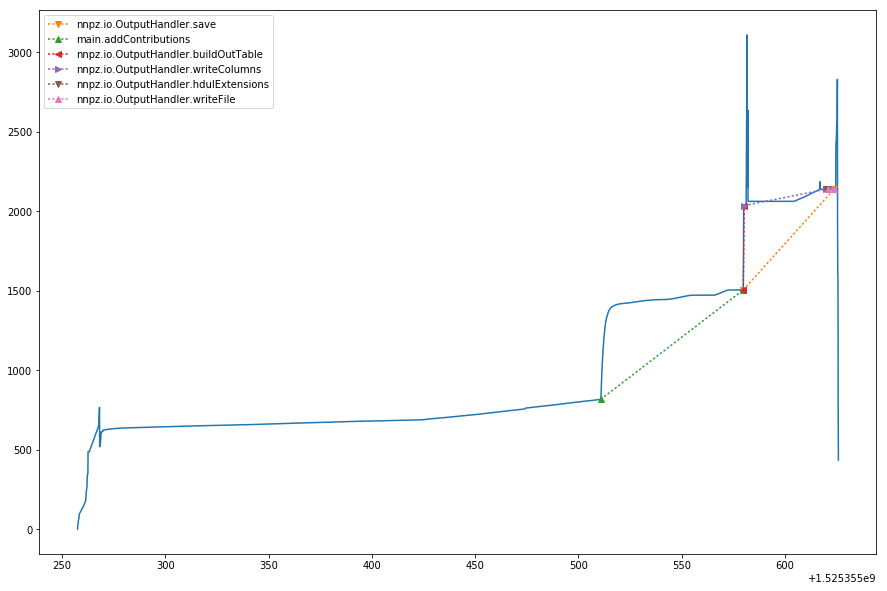

In [11]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180503154737.dat')
plot_mprof(mprof_data)

Oh, come on. Something going out of scope is causing that bump?

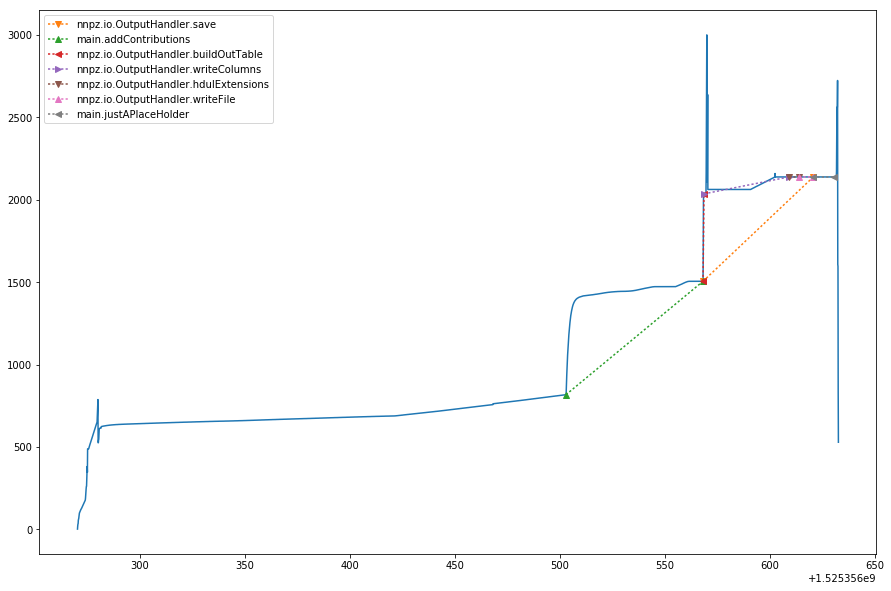

In [12]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180503160430.dat')
plot_mprof(mprof_data)

It's actually happening before exiting O_o
Let's try to figure out if disabling parts of the code this goes away.

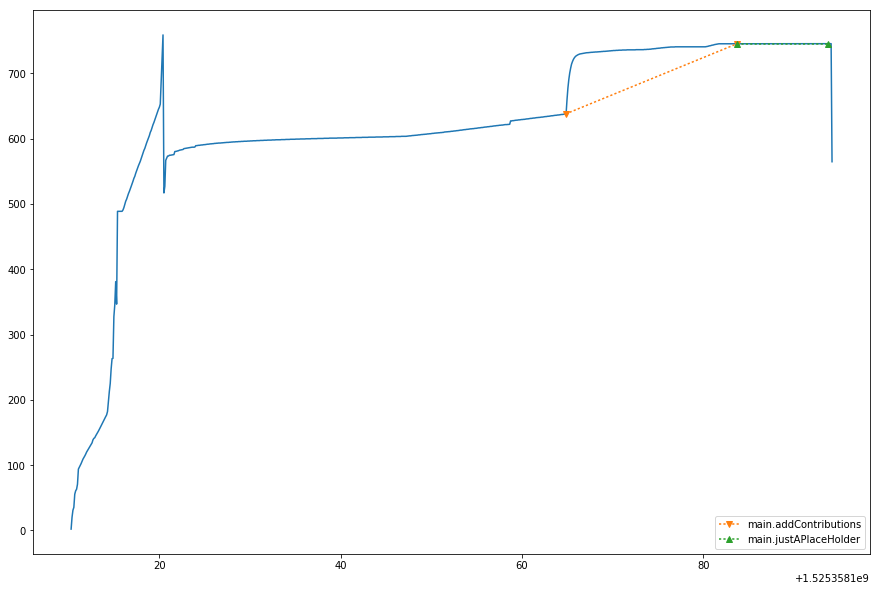

In [15]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180503163510.dat')
plot_mprof(mprof_data)

Something in the .save() is it...

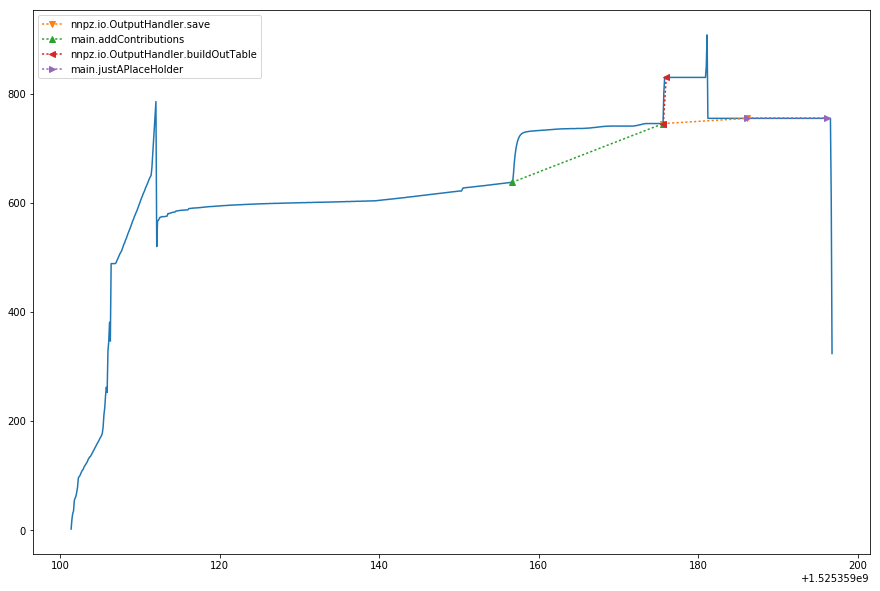

In [24]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/profiles/mprofile_20180503165141.dat')
plot_mprof(mprof_data)

So, something to do with weak references. In case someone is holding a reference to any of the columns, they are copied before the memory hold by FITS_rec is freed. Thus, the memory doubles on destruction.
Blimey.

```python
    def __del__(self):
        try:
            del self._coldefs

            if self.dtype.fields is not None:
                for col in self._col_weakrefs:
                    if col.array is not None:
                        col.array = col.array.copy()

        # See issues #4690 and #4912
        except (AttributeError, TypeError):  # pragma: no cover
            pass
```

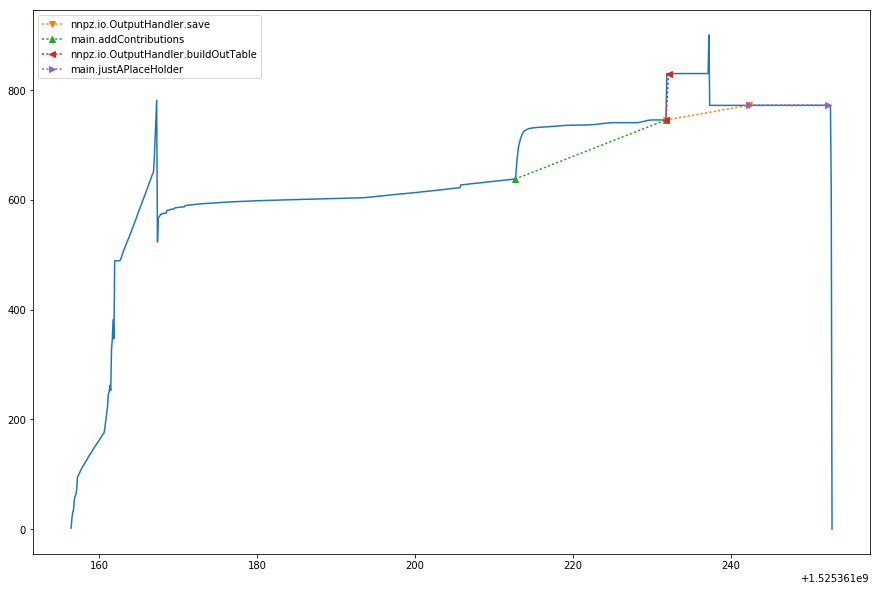

In [27]:
mprof_data = read_mprof('/home/aalvarez/Work/Projects/NNPZ/bin/mprofile_20180503172556.dat')
plot_mprof(mprof_data)